# Model Selection Introduction
PyCoTools can be used to systematically fit data to multiple models. This is done using the MultiModelFit class which internally uses the RunMultiplePEs class. Model selection criteria is calculated using the ModelSelection class and visualized with boxplots. 

Here we pose a toy model selection problem using the kholodenko2000 model. Model variant1 (M1) is the published model, model variant2(M2) has only single phosphorylations and model variant 3 has the same topology as model variant 1 but with mass action rate laws.

## Model Topology for Variants 1 and 3



![ModelVariant1and3](Images/ModelVariant1And3.png)

## Model Topology for Variant2
![ModelVariant2](Images/ModelVariant2.png)


# Manage Directories and imports
The three models are distributed in string format with `PyCoTools` in the `PyCoTools.PyCoToolsTutorial.test_models.TestModels` class. We'll use the `FilePaths` class below to manage directories and to collect the model variants from `TestModels` 

In [4]:
import os,glob
import pandas
import matplotlib.pyplot as plt
import seaborn
import site
site.addsitedir('/home/b3053674/Documents/PyCoTools/')
import PyCoTools

from PyCoTools.PyCoToolsTutorial import test_models
import logging
logging.basicConfig()
LOG=logging.getLogger()
%matplotlib inline

class FilePaths():
    """
    Class to manage directories 
    """
    def __init__(self):
        ## change self.dire to the folder where this file is on your own computer. 
        self.dire = '/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2'
        TM = test_models.TestModels()
        
        ## get model variants from PyCoToolsTutorials.test_model
        self.variant1 = TM.get_kholodenko_variant1()
        self.variant2 = TM.get_kholodenko_variant2()
        self.variant3 = TM.get_kholodenko_variant3()
        
        ## create paths to save the models to file
        self.M1 = os.path.join(self.dire, 'ModelVariant1.cps')
        self.M2 = os.path.join(self.dire, 'ModelVariant2.cps')
        self.M3 = os.path.join(self.dire, 'ModelVariant3.cps')
        
        for model_path, model_string in zip([self.M1, self.M2, self.M3], [self.variant1, self.variant2, self.variant3]):
            with open(model_path, 'w' ) as f:
                f.write(model_string)
                
        
        ## Create a directory to use for the analysis
        self.fit1_dir = os.path.join(self.dire, 'KholodenkoFit1')
        if os.path.isdir(self.fit1_dir)!=True:
            os.mkdir(self.fit1_dir)
        
        
F = FilePaths()

# Synthetic Data Simulation
Model variant 1 is the published kholodenko model. Here we simulate some data from this model to be used in the model selection problem. To make the problem more realistic, global variables have been manually created in each model to represent the total amount of each specie and the total amount of each phospho specie for each model. i.e. 
    
    1. Mos_tot     = Mos + Mos-P
    2. Mos-P_tot   = Mos-P
    3. Mek1_tot    = Mek + Mek-P + Mek-PP
    4. Mek1-P_tot  = Mek-P + Mek-PP
    5. Erk_tot     = Erk + Erk-P + Erk-PP
    6. Erk-P_tot   = Erk-P + Erk-PP

In real life these may represent total and phoso antibodies for some quantified western blot data. 

## Simulate time course from model variant 1 and collect results for global quantities

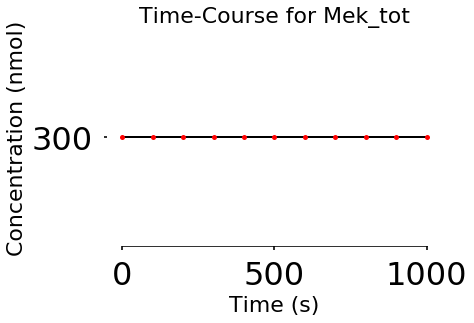

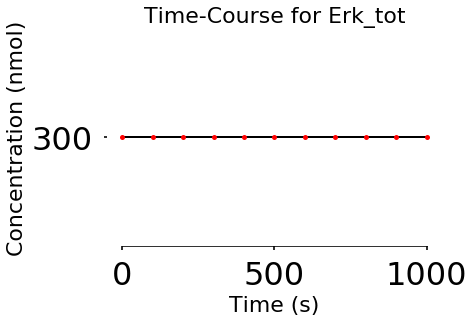

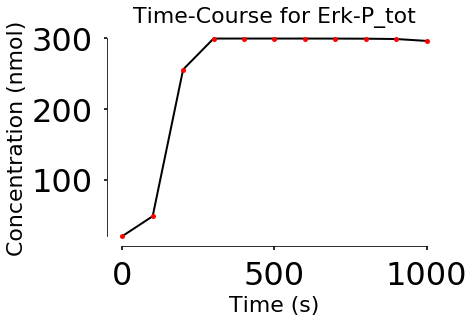

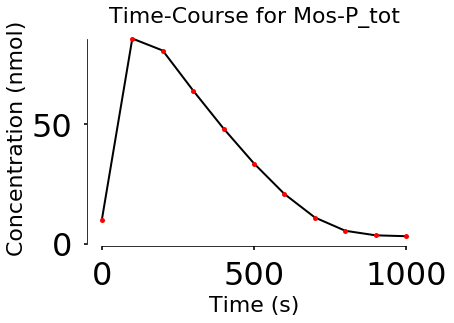

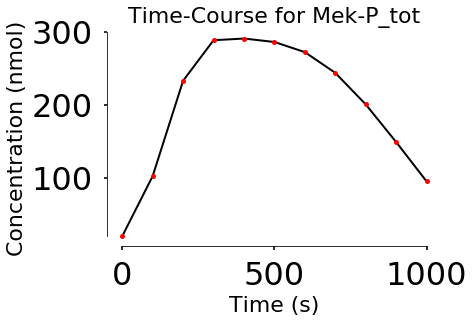

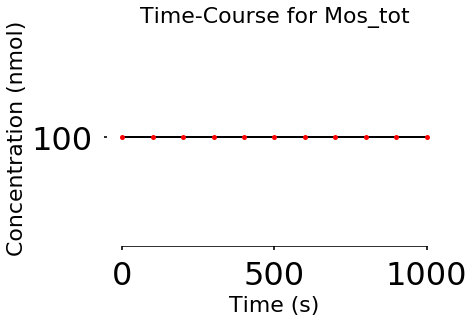

In [5]:
## Use GetModelQuantities to quickly locate our model variables we want to simulate
GMQ = PyCoTools.pycopi.GetModelQuantities(F.M1)
global_quantities = GMQ.get_global_quantities().keys()
## Simulate Synthetic Data
TC = PyCoTools.pycopi.TimeCourse(F.M1, step_size=100, intervals=10, 
                                end=1000, 
                                global_quantities = global_quantities,
                                metabolites=[],plot=True)

Now lets take a look at the results file to ensure everything is as it should be. Note that `Time` is on the far left and the other variable names match
model variables exactly. 

In [6]:
df = pandas.read_csv(TC['report_name'],sep='\t')
df

,Time,Mek_tot,Erk_tot,Erk-P_tot,Mos-P_tot,Mek-P_tot,Mos_tot
0,0,300,300,20.000,10.00000,20.0000,100
1,100,300,300,48.310,85.79510,102.3890,100
2,200,300,300,256.060,80.77590,233.0850,100
3,300,300,300,299.898,64.02640,288.5660,100
4,400,300,300,299.918,48.11770,290.8740,100
5,500,300,300,299.914,33.50880,286.1480,100
6,600,300,300,299.896,20.73060,272.2660,100
7,700,300,300,299.848,10.90740,243.8560,100
8,800,300,300,299.716,5.35040,200.6140,100
9,900,300,300,299.245,3.45521,149.0250,100


# Model selection setup
To setup a model selection problem:
    
    1. Create a new folder dedicated to the analysis. 
    2. Put your copasi model variants into this folder with any data files you want to fit to the model.

Text and csv files are automatically detected and mapped to model variables when you instantiate the MultiModelFit class. These two steps can be done manually but here we'll just do it programmatically:

In [8]:
import shutil
[shutil.copy2(i, F.fit1_dir) for i in [F.M1,
                                       F.M2,
                                       F.M3,
                                       TC['report_name']] ]

[None, None, None, None]

## Use MultiModelFit
Here we set copy_number to 3 and pe_number to 50 to conduct 150 parameter estimations per model variant. The process is very similar to using the `ParameterEstimation` or `RunMultiplePEs` classes

In [9]:
MMF = PyCoTools.pycopi.MultiModelFit(F.fit1_dir,
                                     copy_number=3, pe_number=50,
                                     method='GeneticAlgorithm',
                                     population_size=100,
                                     number_of_generations=300,
                                     lower_bound=1e-3,
                                     upper_bound=1e3)

INFO:PyCoTools.pycopi:pycopi:create_workspace:4806:Creating workspace from project_dir
INFO:PyCoTools.pycopi:pycopi:create_workspace:4832:Workspace created
INFO:PyCoTools.pycopi:pycopi:_create_output_directory:4547:creating a directory for analysis in : 

/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant1/MultipleParameterEsimationAnalysis
INFO:PyCoTools.pycopi:pycopi:_create_output_directory:4547:creating a directory for analysis in : 

/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant3/MultipleParameterEsimationAnalysis
INFO:PyCoTools.pycopi:pycopi:_create_output_directory:4547:creating a directory for analysis in : 

/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant2/MultipleParameterEsimationAnalysis


## Create and Modify  Config File
Use the `write_config_file` argument to write a parameter estimation config file for each model. Then manually open and modify it to represent the estimation problem you want. Here we manually delete rows which do not contain kinetic parameters. 

In [10]:
files = MMF.write_config_template()

INFO:PyCoTools.pycopi:pycopi:write_config_template:4444:writing PE config template for model: /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant2/ModelVariant2.cps
INFO:PyCoTools.pycopi:pycopi:write_config_template:3091:writing config template. overwrite_config_file set to False and config_filename is /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant2/PEConfigFile.xlsx
INFO:PyCoTools.pycopi:pycopi:write_config_template:4444:writing PE config template for model: /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant3/ModelVariant3.cps
INFO:PyCoTools.pycopi:pycopi:write_config_template:3091:writing config template. overwrite_config_file set to False and config_filename is /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant3/PEConfigFile.xlsx
INFO:PyCoTools.pycopi:pycopi:write_config_template:4444:writing PE con

## setup and run

In [11]:
MMF.setup()
MMF.run()

INFO:PyCoTools.pycopi:pycopi:copy_copasi:4426:Copying copasi file 3 times
INFO:PyCoTools.pycopi:pycopi:_setup_scan:4463:setting up scan for model : /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant2/ModelVariant2.cps
INFO:root:pycopi:define_report:3689:defining report
INFO:PyCoTools.pycopi:pycopi:_setup1scan:4496:Setup Took 0.0774419307709 seconds
INFO:PyCoTools.pycopi:pycopi:_setup_scan:4463:setting up scan for model : /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant2/ModelVariant2_1.cps
INFO:root:pycopi:define_report:3689:defining report
INFO:PyCoTools.pycopi:pycopi:_setup1scan:4496:Setup Took 0.0770490169525 seconds
INFO:PyCoTools.pycopi:pycopi:_setup_scan:4463:setting up scan for model : /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test2/KholodenkoFit1/ModelVariant2/ModelVariant2_2.cps
INFO:root:pycopi:define_report:3689:defining report
INFO:PyCoTools.pycopi:pycopi:_setu

## Format output data
COPASI output does not contain informative parameter headers. This means we have to manually infer the parameters using information extracted from the parameter estimation task. The `format_data` method does this for us. Wait until the parameter estimations have finished then use the `format_data` method. You can keep an eye on progress using a task manager/system monitor or equivalent.  

In [6]:
MMF.format_data()

INFO:PyCoTools.pycopi:pycopi:copy_copasi:4426:Copying copasi file 3 times
INFO:PyCoTools.pycopi:pycopi:_setup_scan:4463:setting up scan for model : /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test/ModelSelection/KholodenkoFit1/Kholodenko2000_variant1/Kholodenko2000_variant1.cps
INFO:root:pycopi:define_report:3689:defining report
INFO:PyCoTools.pycopi:pycopi:_setup_scan:4463:setting up scan for model : /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test/ModelSelection/KholodenkoFit1/Kholodenko2000_variant1/Kholodenko2000_variant1_1.cps
INFO:PyCoTools.pycopi:pycopi:_setup1scan:4496:Setup Took 0.143469810486 seconds
INFO:root:pycopi:define_report:3689:defining report
INFO:PyCoTools.pycopi:pycopi:_setup_scan:4463:setting up scan for model : /home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Test/ModelSelection/KholodenkoFit1/Kholodenko2000_variant1/Kholodenko2000_variant1_2.cps
INFO:PyCoTools.pycopi:pycopi:_setup1scan:4496:Setup Took 0.1382849

## Model Selection
Now we can use the ModelSelection class to calculate AICc and BIC

In [7]:
MS = PyCoTools.PEAnalysis.ModelSelection(MMF)
model_selection_criteria = MS.calculate_model_selection_criteria()
## write dataframe to file
model_selection_criteria.to_csv(os.path.join(F.fit1_dir, 'ModelSelectionCriteria.csv'))

INFO:PyCoTools.PEAnalysis:PEAnalysis:_parse_data:1176:data successfully parsed from 3 models into Python
INFO:PyCoTools.PEAnalysis:PEAnalysis:_get_n:1207:Counting number of observed data points:...


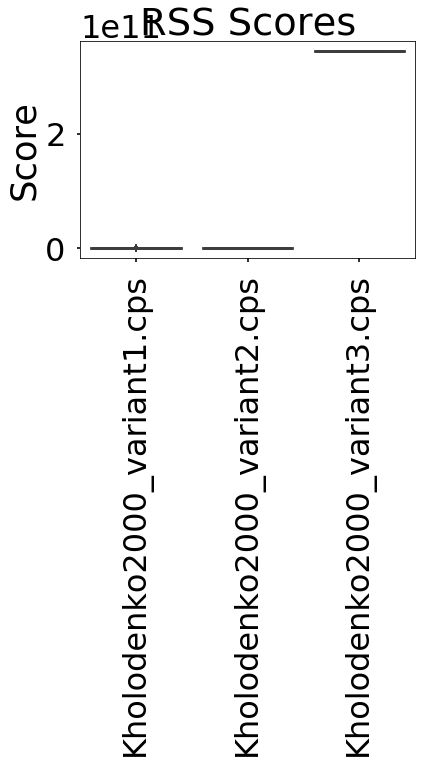

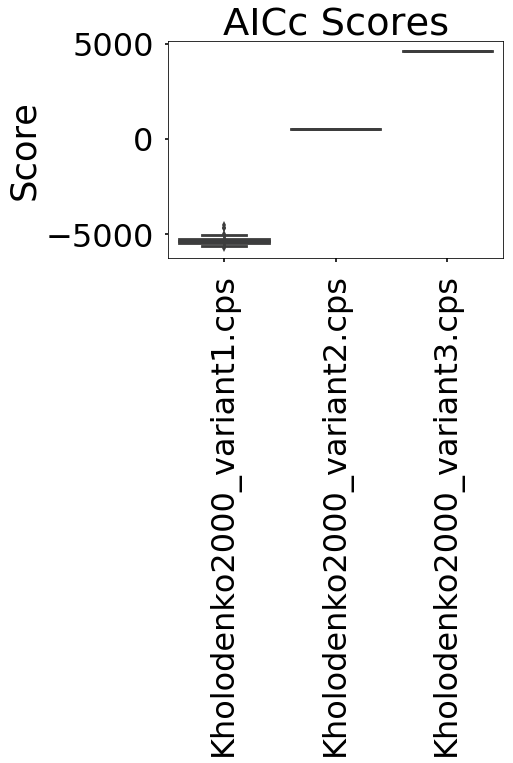

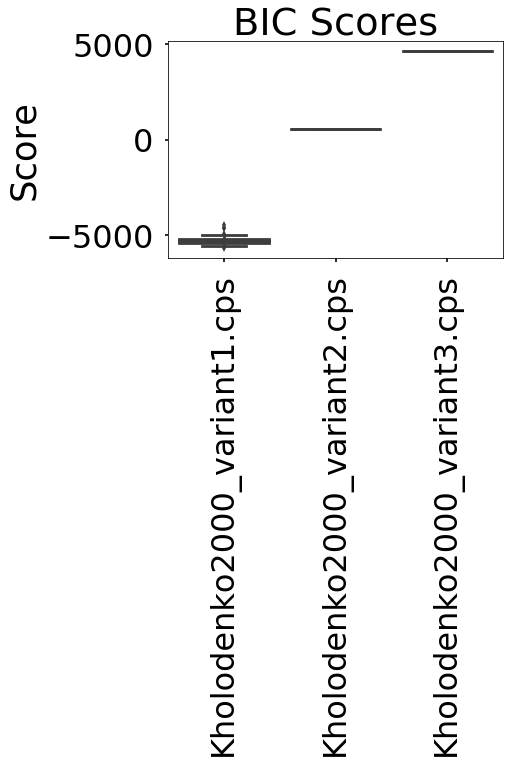

In [8]:
MS.plot_boxplot()